# Homework 3

I will be working with the Yelp dataset of reviews: https://www.yelp.com/dataset.
More specifically, I will be using the review dataset, which contains integer ratings (1-5) and accompanying text.

In [9]:
import os
import json
import timeit
import pandas as pd
import seaborn as sns
import multiprocessing
import tqdm
import pickle

import gensim
from gensim import utils
from nltk.corpus import stopwords
# from p_tqdm import p_map
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC

In [2]:
# Size of dataset
!ls -l yelp_data/yelp_academic_dataset_review.json 

-rw-r--r--@ 1 kristiyan  staff  6325565224 Dec 13  2019 yelp_data/yelp_academic_dataset_review.json


Approximately 6.33 GB

In [3]:
# Number of reviews
!wc -l yelp_data/yelp_academic_dataset_review.json

 8021122 yelp_data/yelp_academic_dataset_review.json


Approximately 8 million reviews

## Importing .5 million reviews

In [2]:
datapath = os.path.join(os.getcwd(),'yelp_data', 'yelp_academic_dataset_review.json')

In [3]:
def access_yelp_reviews(datapath, n_reviews=500_000):
    
    # Initialize empty output
    reviews = []
    ratings = []
    counter = 0
    
    with open(datapath, 'r', encoding='utf8') as filehandle:
        
        while counter < n_reviews:
            
            line = json.loads(filehandle.readline())
            
            if counter % 99_000 == 0:
                print(f'Accessed {counter} reviews')
                
            reviews.append(line['text'])
            ratings.append(line['stars'])
            
            counter += 1
            
    return reviews, ratings
    

In [4]:
reviews, ratings = access_yelp_reviews(datapath)

Accessed 0 reviews
Accessed 100000 reviews
Accessed 200000 reviews
Accessed 300000 reviews
Accessed 400000 reviews


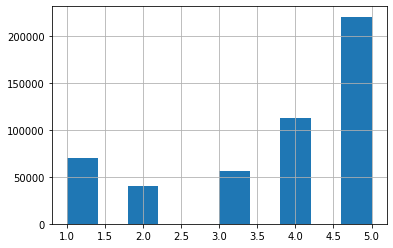

In [5]:
pd.Series(ratings).hist()

In [38]:
pd.Series(ratings).value_counts(normalize=True)

5.0    0.440750
4.0    0.225604
1.0    0.140936
3.0    0.111556
2.0    0.081154
dtype: float64

In [8]:
def remove_stopwords(tokenized_sentence:str):
    
    return [word for word in tokenized_sentence if word not in stopwords.words('english')]


def preprocess_text(text:str):
    """Converts text to sentences; tokenizes sentences; removes all stopword tokens"""
    
    # Preprocess each sentence converting it into a list of lower case tokens, which are not too long or too short
    tokenized_text = gensim.utils.simple_preprocess(text)
    
    # Remove any tokens which are stop words
    no_stops = remove_stopwords(tokenized_text)
        
    return no_stops

In [9]:
pool=multiprocessing.Pool(multiprocessing.cpu_count())

In [11]:
%timeit -r1 pool.map(preprocess_text, reviews[:10000])

31.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
# I'm expecting this to take ~ half an hour; Time to go to the supermarket!
preprocessed_reviews = pool.map(preprocess_text, reviews)

In [32]:
pool.close()

In [21]:
# # Saving preprocessed reviews to pickle file
# with open('preprocessed_reviews.pkl', 'wb') as f:
#     pickle.dump(preprocessed_reviews, f)

In [6]:
# Reading in the pickled processed reviews
with open('preprocessed_reviews.pkl', 'rb') as f:
    preprocessed_reviews = pickle.load(f)

In [23]:
number_words = 0
number_characters = 0
for review in preprocessed_reviews:
    for word in review:
        number_words += 1
        number_characters += len(word)

In [24]:
number_words

26637338

In [25]:
number_characters

150093818

In [26]:
number_characters/number_words

5.634715375838232

We have 26.6 million words with a total of 150 million characters, giving us an average word length of 5.634

# Converting to BOW and TFIDF with sklearn

In [14]:
# Need the preprocessed_reviews as entire sentences, not lists of tokens
preprocessed_reviews_strings = [" ".join(review) for review in preprocessed_reviews]

In [ ]:
# # Saving preprocessed reviews with bigrams to pickle file
# with open('preprocessed_reviews_strings.pkl', 'wb') as f:
#     pickle.dump(preprocessed_reviews_strings, f)

In [7]:
# Reading in the pickled preprocessed reviews with bigrams
with open('preprocessed_reviews_strings.pkl', 'rb') as f:
    preprocessed_reviews_strings = pickle.load(f)

In [9]:
count_vectorizer = CountVectorizer(lowercase=False, ngram_range =(1,2), max_df = .5, min_df = 100)
uni_and_bigram_bow_corpus = count_vectorizer.fit_transform(preprocessed_reviews_strings)
uni_and_bigram_bow_corpus

<500000x34936 sparse matrix of type '<class 'numpy.int64'>'
	with 28756260 stored elements in Compressed Sparse Row format>

In [15]:
# BOW unigrams - Also same value as from gensim Dictionary and filter extremes!
count_vectorizer = CountVectorizer(lowercase=False, ngram_range =(1,1), max_df = .5, min_df = 100)
unigram_bow_corpus = count_vectorizer.fit_transform(preprocessed_reviews_strings)
unigram_bow_corpus

<500000x11147 sparse matrix of type '<class 'numpy.int64'>'
	with 21615399 stored elements in Compressed Sparse Row format>

In [10]:
# TFIDF unigrams
tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range =(1,1), max_df = .5, min_df = 100)
unigram_tfidf_corpus = tfidf_vectorizer.fit_transform(preprocessed_reviews_strings)
unigram_tfidf_corpus

<500000x11147 sparse matrix of type '<class 'numpy.float64'>'
	with 21615399 stored elements in Compressed Sparse Row format>

In [11]:
# TFIDF unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range =(1,2), max_df = .5, min_df = 100)
uni_and_bigram_tfidf_corpus = tfidf_vectorizer.fit_transform(preprocessed_reviews_strings)
uni_and_bigram_tfidf_corpus

<500000x34936 sparse matrix of type '<class 'numpy.float64'>'
	with 28756260 stored elements in Compressed Sparse Row format>

In [16]:
# Saving preprocessed reviews with bigrams to pickle file
with open('uni_and_bigram_bow_corpus.pkl', 'wb') as f:
    pickle.dump(uni_and_bigram_bow_corpus, f)

# Saving preprocessed reviews with bigrams to pickle file
with open('unigram_bow_corpus.pkl', 'wb') as f:
    pickle.dump(unigram_bow_corpus, f)

# Saving preprocessed reviews with bigrams to pickle file
with open('unigram_tfidf_corpus.pkl', 'wb') as f:
    pickle.dump(unigram_tfidf_corpus, f)

# Saving preprocessed reviews with bigrams to pickle file
with open('uni_and_bigram_tfidf_corpus.pkl', 'wb') as f:
    pickle.dump(uni_and_bigram_tfidf_corpus, f)

In [5]:
# Reading in saved corpuses
with open('uni_and_bigram_bow_corpus.pkl', 'rb') as f:
    uni_and_bigram_bow_corpus=pickle.load(f)


with open('unigram_bow_corpus.pkl', 'rb') as f:
    unigram_bow_corpus=pickle.load(f)


with open('unigram_tfidf_corpus.pkl', 'rb') as f:
    unigram_tfidf_corpus=pickle.load(f)


with open('uni_and_bigram_tfidf_corpus.pkl', 'rb') as f:
    uni_and_bigram_tfidf_corpus=pickle.load(f)

# Logistic Regression

Can try different regularization (l1, l2, or elastic net which is a combo of the two)

In [6]:
corpuses = {'unigram_bow':unigram_bow_corpus, 
            'uni_bigram_bow': uni_and_bigram_bow_corpus, 
            'unigram_tfidf': unigram_tfidf_corpus, 
            'uni_bigram_tfidf': uni_and_bigram_tfidf_corpus}

models = {'LogReg':LogisticRegression}

def a_few_models(model_type = 'LogReg', corpus = 'unigram_bow', **kwargs):
    print("--------------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(corpuses[corpus], ratings, random_state=42)
    
    print(f"MODEL TYPE: {model_type}; CORPUS: {corpus}")
    print(f"MODEL PARAMETERS PROVIDED: {kwargs}")
    model = models[model_type](**kwargs)
    print(model.get_params())
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    print(f"TRAINING ACCURACY: {accuracy_score(y_train, y_pred_train)}")
    
    y_pred = model.predict(X_test)
    print(f"TEST DATA - CLASSIFICATION REPORT")
    print(classification_report(y_test, y_pred))
    print(f"WEIGHTED PRECISION: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"WEIGHTED Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"WEIGHTED F1: {f1_score(y_test, y_pred, average = 'weighted')}")

In [29]:
for corpus_ in corpuses:
    for n_iter in range(100, 301, 100):
        a_few_models(corpus=corpus_ , n_jobs=8, max_iter=n_iter)

MODEL TYPE: LogReg; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'n_jobs': 8, 'max_iter': 100}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': 8, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
TRAINING ACCURACY: 0.696688
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.72      0.82      0.77     17545
         2.0       0.45      0.30      0.36     10235
         3.0       0.47      0.36      0.41     13855
         4.0       0.53      0.42      0.47     28358
         5.0       0.74      0.88      0.81     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.56      0.56    125000
weighted avg       0.64      0.66      0.64    125000

WEIGHTED PRECISION: 0.6379283452836969
WEIGHTED Recall: 0.662776
WEIGHTED F1:

## L1 Regularization with liblinear solver

In [7]:
for corpus_ in corpuses:
    for C_ in [.5,1,2]: # Strength of regularization
#         for l1_ratio_ in [.2, .5, .8]: # .2 is more L2 reg. than L1; .8 is more L1 than L2
        a_few_models(corpus=corpus_ , C=C_, solver='liblinear', penalty='l1', verbose=20) # l1_ratio=l1_ratio_

--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'solver': 'liblinear', 'penalty': 'l1', 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 20, 'warm_start': False}
[LibLinear]TRAINING ACCURACY: 0.6922826666666667
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.72      0.82      0.77     17545
         2.0       0.47      0.24      0.32     10235
         3.0       0.49      0.31      0.38     13855
         4.0       0.52      0.40      0.45     28358
         5.0       0.72      0.90      0.80     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.53      0.54    125000
weighted avg       0.63      

## L2 Regularization with lbfgs

In [8]:
for corpus_ in corpuses:
    for C_ in [.5,1,2]: # Strength of regularization
#         for l1_ratio_ in [.2, .5, .8]: # .2 is more L2 reg. than L1; .8 is more L1 than L2
        a_few_models(corpus=corpus_ , C=C_, penalty='l2', verbose=20) # l1_ratio=l1_ratio_

--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'penalty': 'l2', 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 20, 'warm_start': False}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


TRAINING ACCURACY: 0.6988026666666667
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.73      0.82      0.77     17545
         2.0       0.45      0.31      0.37     10235
         3.0       0.47      0.35      0.40     13855
         4.0       0.53      0.43      0.47     28358
         5.0       0.75      0.88      0.81     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.56      0.56    125000
weighted avg       0.64      0.66      0.64    125000

WEIGHTED PRECISION: 0.6386146352326914
WEIGHTED Recall: 0.6626
WEIGHTED F1: 0.6448180438829698
--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 1, 'penalty': 'l2', 'verbose': 20}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


TRAINING ACCURACY: 0.696688
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.72      0.82      0.77     17545
         2.0       0.45      0.30      0.36     10235
         3.0       0.47      0.36      0.41     13855
         4.0       0.53      0.42      0.47     28358
         5.0       0.74      0.88      0.81     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.56      0.56    125000
weighted avg       0.64      0.66      0.64    125000

WEIGHTED PRECISION: 0.6379283452836969
WEIGHTED Recall: 0.662776
WEIGHTED F1: 0.6436408383729924
--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 2, 'penalty': 'l2', 'verbose': 20}
{'C': 2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


TRAINING ACCURACY: 0.6972746666666667
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.73      0.82      0.77     17545
         2.0       0.46      0.30      0.36     10235
         3.0       0.47      0.35      0.40     13855
         4.0       0.53      0.42      0.47     28358
         5.0       0.74      0.88      0.81     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.55      0.56    125000
weighted avg       0.64      0.66      0.64    125000

WEIGHTED PRECISION: 0.637158965348075
WEIGHTED Recall: 0.662424
WEIGHTED F1: 0.6428910171825342
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_bow
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'penalty': 'l2', 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'rand

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


TRAINING ACCURACY: 0.7502346666666667
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.74      0.81      0.78     17545
         2.0       0.46      0.36      0.40     10235
         3.0       0.47      0.41      0.44     13855
         4.0       0.53      0.43      0.48     28358
         5.0       0.76      0.87      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.58      0.58    125000
weighted avg       0.65      0.67      0.66    125000

WEIGHTED PRECISION: 0.6493088953219472
WEIGHTED Recall: 0.668304
WEIGHTED F1: 0.655093180280955
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_bow
MODEL PARAMETERS PROVIDED: {'C': 1, 'penalty': 'l2', 'verbose': 20}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


TRAINING ACCURACY: 0.7485333333333334
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.75      0.81      0.78     17545
         2.0       0.46      0.36      0.40     10235
         3.0       0.47      0.41      0.44     13855
         4.0       0.53      0.46      0.49     28358
         5.0       0.77      0.86      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.58      0.58    125000
weighted avg       0.65      0.67      0.66    125000

WEIGHTED PRECISION: 0.6513387417009029
WEIGHTED Recall: 0.668088
WEIGHTED F1: 0.6571981829041221
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_bow
MODEL PARAMETERS PROVIDED: {'C': 2, 'penalty': 'l2', 'verbose': 20}
{'C': 2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


TRAINING ACCURACY: 0.749176
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.74      0.81      0.78     17545
         2.0       0.46      0.36      0.40     10235
         3.0       0.47      0.40      0.43     13855
         4.0       0.53      0.45      0.49     28358
         5.0       0.76      0.86      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.58      0.58    125000
weighted avg       0.65      0.67      0.66    125000

WEIGHTED PRECISION: 0.6498413923195301
WEIGHTED Recall: 0.667576
WEIGHTED F1: 0.6558415137489275
--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'penalty': 'l2', 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state':

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


TRAINING ACCURACY: 0.6892026666666666
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.73      0.83      0.77     17545
         2.0       0.47      0.28      0.35     10235
         3.0       0.47      0.39      0.43     13855
         4.0       0.53      0.47      0.50     28358
         5.0       0.76      0.86      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.57      0.57    125000
weighted avg       0.65      0.67      0.66    125000

WEIGHTED PRECISION: 0.6494102606545963
WEIGHTED Recall: 0.669752
WEIGHTED F1: 0.655083064257158
--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 1, 'penalty': 'l2', 'verbose': 20}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_st

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


TRAINING ACCURACY: 0.689648
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.72      0.83      0.77     17545
         2.0       0.46      0.30      0.36     10235
         3.0       0.48      0.37      0.42     13855
         4.0       0.53      0.48      0.50     28358
         5.0       0.77      0.86      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.57      0.57    125000
weighted avg       0.65      0.67      0.65    125000

WEIGHTED PRECISION: 0.6488112051757188
WEIGHTED Recall: 0.669408
WEIGHTED F1: 0.6548171565104824
--------------------------------------
MODEL TYPE: LogReg; CORPUS: unigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 2, 'penalty': 'l2', 'verbose': 20}
{'C': 2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': Non

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


TRAINING ACCURACY: 0.6897813333333334
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.73      0.82      0.77     17545
         2.0       0.45      0.31      0.37     10235
         3.0       0.47      0.38      0.42     13855
         4.0       0.53      0.49      0.51     28358
         5.0       0.77      0.85      0.81     55007

    accuracy                           0.67    125000
   macro avg       0.59      0.57      0.58    125000
weighted avg       0.65      0.67      0.66    125000

WEIGHTED PRECISION: 0.6499226305691314
WEIGHTED Recall: 0.668104
WEIGHTED F1: 0.6559383060354157
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'penalty': 'l2', 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


TRAINING ACCURACY: 0.7105733333333333
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.74      0.83      0.78     17545
         2.0       0.50      0.32      0.39     10235
         3.0       0.51      0.37      0.43     13855
         4.0       0.54      0.49      0.52     28358
         5.0       0.77      0.87      0.82     55007

    accuracy                           0.68    125000
   macro avg       0.61      0.58      0.59    125000
weighted avg       0.66      0.68      0.67    125000

WEIGHTED PRECISION: 0.6609777041589375
WEIGHTED Recall: 0.6806
WEIGHTED F1: 0.6656007449201992
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 1, 'penalty': 'l2', 'verbose': 20}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


TRAINING ACCURACY: 0.7173653333333333
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.73      0.83      0.78     17545
         2.0       0.49      0.33      0.39     10235
         3.0       0.50      0.38      0.43     13855
         4.0       0.54      0.50      0.52     28358
         5.0       0.77      0.86      0.82     55007

    accuracy                           0.68    125000
   macro avg       0.61      0.58      0.59    125000
weighted avg       0.66      0.68      0.67    125000

WEIGHTED PRECISION: 0.6611203761166411
WEIGHTED Recall: 0.678968
WEIGHTED F1: 0.6661083943675812
--------------------------------------
MODEL TYPE: LogReg; CORPUS: uni_bigram_tfidf
MODEL PARAMETERS PROVIDED: {'C': 2, 'penalty': 'l2', 'verbose': 20}
{'C': 2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'rando

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished


TRAINING ACCURACY: 0.7189946666666667
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.74      0.83      0.78     17545
         2.0       0.48      0.34      0.40     10235
         3.0       0.49      0.40      0.44     13855
         4.0       0.54      0.49      0.51     28358
         5.0       0.78      0.86      0.81     55007

    accuracy                           0.68    125000
   macro avg       0.60      0.58      0.59    125000
weighted avg       0.66      0.68      0.67    125000

WEIGHTED PRECISION: 0.6608930457345766
WEIGHTED Recall: 0.6778
WEIGHTED F1: 0.6663600226821427


In [14]:
with open('ratings.pkl', 'wb') as f:
    pickle.dump(ratings, f)

In [20]:
pred = [1, 5]
keys = ['label']*len(pred)
keys
# dict(zip(keys,pred))

['label', 'label']

# SVM

In [11]:
corpuses = {'unigram_bow':unigram_bow_corpus, 
            'uni_bigram_bow': uni_and_bigram_bow_corpus, 
            'unigram_tfidf': unigram_tfidf_corpus, 
            'uni_bigram_tfidf': uni_and_bigram_tfidf_corpus}

models = {'LogReg':LogisticRegression, 'SVM':LinearSVC}

def a_few_models(model_type = 'LogReg', corpus = 'unigram_bow', **kwargs):
    print("--------------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(corpuses[corpus], ratings, random_state=42)
    
    print(f"MODEL TYPE: {model_type}; CORPUS: {corpus}")
    print(f"MODEL PARAMETERS PROVIDED: {kwargs}")
    model = models[model_type](**kwargs)
    print(model.get_params())
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    print(f"TRAINING ACCURACY: {accuracy_score(y_train, y_pred_train)}")
    
    y_pred = model.predict(X_test)
    print(f"TEST DATA - CLASSIFICATION REPORT")
    print(classification_report(y_test, y_pred))
    print(f"WEIGHTED PRECISION: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"WEIGHTED Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"WEIGHTED F1: {f1_score(y_test, y_pred, average = 'weighted')}")

In [13]:
for corpus_ in corpuses:
    for C_ in [.5,1,2]: # Strength of regularization
        a_few_models(model_type = 'SVM', corpus=corpus_ , C=C_, verbose=20)

--------------------------------------
MODEL TYPE: SVM; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 0.5, 'verbose': 20}
{'C': 0.5, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 20}
[LibLinear]

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TRAINING ACCURACY: 0.691936
TEST DATA - CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       0.70      0.82      0.76     17545
         2.0       0.45      0.24      0.31     10235
         3.0       0.47      0.29      0.36     13855
         4.0       0.52      0.38      0.44     28358
         5.0       0.71      0.91      0.80     55007

    accuracy                           0.65    125000
   macro avg       0.57      0.53      0.53    125000
weighted avg       0.62      0.65      0.62    125000

WEIGHTED PRECISION: 0.618654166568615
WEIGHTED Recall: 0.650976
WEIGHTED F1: 0.6212519452949821
--------------------------------------
MODEL TYPE: SVM; CORPUS: unigram_bow
MODEL PARAMETERS PROVIDED: {'C': 1, 'verbose': 20}
{'C': 1, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 20}


In [15]:
y_pred

NameError: name 'y_pred' is not defined

# Appendix

If you want to load the sparse matrix file that’s being written here, you can use this: from sklearn.datasets import load_svmlight_file X,y = load_svmlight_file('./review.liblinear')

## Preprocessing with gensim - the long way

In [3]:
# Now I need to create a separate set of reviews, which contains unigrams & bigrams
def uni_and_bigrams(tokens):
    # the bigrams just contatenate 2 adjacent tokens with _ in between
    bigrams=list(map(lambda x: '_'.join(x), zip(tokens, tokens[1:])))
    # returning a list containing all 1 and 2-grams
    return tokens+bigrams

In [6]:
pool=multiprocessing.Pool(multiprocessing.cpu_count())
preprocessed_reviews_with_bigrams = pool.map(uni_and_bigrams, preprocessed_reviews)
pool.close()

In [7]:
# # Saving preprocessed reviews with bigrams to pickle file
# with open('preprocessed_reviews_with_bigrams.pkl', 'wb') as f:
#     pickle.dump(preprocessed_reviews_with_bigrams, f)

In [ ]:
# # Reading in the pickled preprocessed reviews with bigrams
# with open('preprocessed_reviews_with_bigrams.pkl', 'rb') as f:
#     preprocessed_reviews_with_bigrams = pickle.load(f)

In [8]:
# Creating a dictionary for unigrams
unigram_dict = gensim.corpora.Dictionary(preprocessed_reviews)

In [12]:
len(unigram_dict)

158021

The total vocabulary size is 158k unigrams

In [18]:
# Now I need to convert the two corpuses to BoW representation
unigram_dict.filter_extremes(no_below = 100, no_above = .5)

In [19]:
len(unigram_dict)

11147

Vocabulary size is drastically reduced to just 11,147 words after removing rare words appearing in fewer than 100 review and very frequent ones in more than half of all docs

In [20]:
# saving to pickle file
unigram_dict.save('unigram_dict.pkl')

In [13]:
# Creating a dictionary for unigrams & bigrams
uni_and_bigram_dict = gensim.corpora.Dictionary(preprocessed_reviews_with_bigrams)

In [16]:
len(uni_and_bigram_dict)

2176877

The total vocabulary size is now ~ 10x larger at 2.2 million unigrams and bigrams than the original unigram vocabulary

In [21]:
uni_and_bigram_dict.filter_extremes(no_below = 100, no_above = .5)

In [22]:
len(uni_and_bigram_dict)

34936

The vocabulary is again drastically reduced to just ~35k words

In [23]:
# saving to pickle file
uni_and_bigram_dict.save('uni_and_bigram_dict.pkl')

# Converting to BOW and TFIDF w/ gensim -> works, but breaks when I try to use it to fit LogReg

I want to have both a BOW and TFIDF representation so I can compare performance in the end

In [24]:
# BOW corpus for unigrams
unigram_bow_corpus = [unigram_dict.doc2bow(review) for review in preprocessed_reviews]

In [28]:
# BOW corpus for unigrams & bigrams
uni_and_bigram_bow_corpus = [uni_and_bigram_dict.doc2bow(review) for review in preprocessed_reviews_with_bigrams]

In [32]:
# TFIDF corpus for unigrams 
unigram_tfidf_model = gensim.models.TfidfModel(corpus=unigram_bow_corpus)
unigram_tfidf_corpus = unigram_tfidf_model[unigram_bow_corpus]

In [30]:
# TFIDF corpus for unigrams & bigrams
unigram_tfidf_model = gensim.models.TfidfModel(dictionary=unigram_dict)
unigram_tfidf_corpus = unigram_tfidf_model[unigram_bow_corpus]

# LogReg - the long way

In [7]:
X_train, X_test, y_train, y_test = train_test_split(unigram_bow_corpus, ratings, random_state=42)

### With 100 iterations

In [8]:
# LogReg with defaults is: penalty = l2, tol (tolerance) is 10^-4, C (inverse of regularization strength) = 1 (smaller number = stronger regularization)
# max_iter = 100 (maximum solver iterations), solver = 'lbfgs'
model = LogisticRegression(n_jobs=8)
model.fit(X_train, y_train)

LogisticRegression(n_jobs=8)

In [9]:
# Training Accuracy
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.696688

In [10]:
y_pred = model.predict(X_test)

In [11]:
confusion_matrix(y_test, y_pred)

array([[14347,  1565,   530,   295,   808],
       [ 3526,  3084,  2183,   795,   647],
       [ 1168,  1653,  5024,  4000,  2010],
       [  404,   348,  2480, 11793, 13333],
       [  459,   143,   542,  5264, 48599]])

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.72      0.82      0.77     17545
         2.0       0.45      0.30      0.36     10235
         3.0       0.47      0.36      0.41     13855
         4.0       0.53      0.42      0.47     28358
         5.0       0.74      0.88      0.81     55007

    accuracy                           0.66    125000
   macro avg       0.58      0.56      0.56    125000
weighted avg       0.64      0.66      0.64    125000



In [42]:
accuracy_score(y_test, y_pred)

0.662776

In [43]:
precision_score(y_test, y_pred, average='weighted') # verifying calculation: (.72*17545 + .45*10235 + .47*13855 + .53*28358 + .74*55007)/125000

0.6379283452836969

In [44]:
recall_score(y_test, y_pred, average='weighted')

0.662776

In [45]:
f1_score(y_test, y_pred, average = 'weighted')

0.6436408383729924

### With 200 iterations

In [46]:
# LogReg with defaults is: penalty = l2, tol (tolerance) is 10^-4, C (inverse of regularization strength) = 1 (smaller number = stronger regularization)
# max_iter = 100 (maximum solver iterations), solver = 'lbfgs'
model = LogisticRegression(n_jobs=8, max_iter = 200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200, n_jobs=8)

In [47]:
# Training Accuracy
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7063786666666667

In [48]:
y_pred = model.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred)

0.65916

In [50]:
precision_score(y_test, y_pred, average='weighted')

0.6360036182877317

In [51]:
recall_score(y_test, y_pred, average='weighted')

0.65916

In [52]:
f1_score(y_test, y_pred, average = 'weighted')

0.6423979020627302

### With 500 iterations

In [53]:
# LogReg with defaults is: penalty = l2, tol (tolerance) is 10^-4, C (inverse of regularization strength) = 1 (smaller number = stronger regularization)
# max_iter = 100 (maximum solver iterations), solver = 'lbfgs'
model = LogisticRegression(n_jobs=8, max_iter = 500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=8)

In [54]:
# Training Accuracy
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7094293333333334

In [55]:
y_pred = model.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.658264

In [57]:
precision_score(y_test, y_pred, average='weighted')

0.6350648974804008

In [58]:
recall_score(y_test, y_pred, average='weighted')

0.658264

In [59]:
f1_score(y_test, y_pred, average = 'weighted')

0.6415278269031528

### With 1000 iterations

In [20]:
# LogReg with defaults is: penalty = l2, tol (tolerance) is 10^-4, C (inverse of regularization strength) = 1 (smaller number = stronger regularization)
# max_iter = 100 (maximum solver iterations), solver = 'lbfgs'
model = LogisticRegression(n_jobs=8, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=8)

In [21]:
# Training Accuracy
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7096613333333334

In [22]:
y_pred = model.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.658512

In [34]:
precision_score(y_test, y_pred, average='weighted')

0.6353323647024285

In [37]:
recall_score(y_test, y_pred, average='weighted')

0.658512

In [28]:
f1_score(y_test, y_pred, average = 'weighted')

0.6417969581340978

## Try CV with LogReg
Takes ages, cancelling

In [18]:
# clf = LogisticRegressionCV(Cs = 3, cv=3, random_state=42, n_jobs=5).fit(unigram_bow_corpus, ratings)

## Batch Processing with parallelism & tqdm?
Getting unpleasant macOS error

In [11]:
# Below uses p_map which is a wrapper for tqdm and multiprocessing.
# Due to some Python/macOS Catalina issues, this doesn't appear to be working
# See: https://github.com/gammapy/gammapy/issues/2453

preprocessed_reviews = []

for batch in batches:
    
    batch_reviews = reviews[batch:batch+10_000]
    
    preprocessed_batch = p_map(preprocess_text, reviews[:100])
    
    print(f"completed batch {batch}")
    
    preprocessed_reviews.extend(preprocessed_batch)


completed batch 0



completed batch 10000


KeyboardInterrupt: 